In [5]:
import pandas as pd
import numpy as np
import math
from numpy.random import rand
import matplotlib.pyplot as plt
from functools import reduce
from itertools import accumulate
from functools import wraps
from sklearn.datasets import make_classification
from mpl_toolkits.mplot3d import Axes3D 
import warnings

In [6]:
warnings.filterwarnings("ignore")

In [7]:
import visualizacoes as vs
from utils import get_hyperplane, load_dataset, Classificador

### Gradient Descent

Agora que vimos a intuição por trás de uma otimização simples, vamos introduzir um dos algoritmos interativos mais utilizados por cientístas para ajustar modelos lineares: a __descida de gradiente__. O gradiente pode ser entendido como uma estrutura n-dimensional formada relacionando o erro de um modelo, quantificado através de uma função de __custo__, com os pesos $w$ do modelo. A lógica é simples: queremos o conjunto de pesos que minimiza a função de custo. O objetivo do algoritmo interativo é portanto, encontrar esse conjunto de pesos. A solução ótima nesse contexto, ou seja, o conjunto de pesos que entre todas as combinações possíveis, retorna o menor erro, é chamado de __mínimo global__ do gradiente. No entanto, o gradiente formado pela função de custo raramente será o de uma função convexa como a acima, mas sim, uma estrutura mais complexa como o exemplo abaixo:

<img src='https://miro.medium.com/max/1406/1*t4aYsxpCqz2eymJ4zkUS9Q.png' width='500px'>

Repare que embora exista uma solução ideal, existem caminhos que leval a soluções locais satisfatórias (ou as vezes não). Esses são os chamados __mínimos locais__ do gradiente.

#### Intuição por trás do algoritmo

Entender o algoritmo de gradient descent não é uma tarefa simples. É um algoritmo que embora não seja tão complexo, é bastante robusto e usado até hoje para treinar modelos complexos como as redes neurais que veremos mais a frente. Muitos artigos, canais e blogs utilizam-se da analogia da montanha para explicar visualmente esse algoritmo, e de fato, podemos encontrar uma bela analogia: Imagine que você está no topo de uma montanha, e você precisa descer ela até a base. Óbviamente existe um caminho mais rápido e direto: 

<img src='https://datascience-enthusiast.com/figures/cost.jpg' width='500px'>

Porém, a vida não é um mar de rosas, e nesse dia, a visibilidade era péssima devido a neblina, e você não é capaz de ver mais do que 5 metros a frente. O que você pode fazer nesse caso, ao invés de sair correndo numa disparado pelo caminho mais curto até a base, é dar passos menores e ir gradativamente descendo, passo a passo, até não conseguir mais descer, e o ato de estar __descendo__ é sua única referência de que você está no caminho certo, afinal, se você começar a subir, você sabe que está indo na direção errada!

Basicamente, é isso que ocorre na vida real com esse algoritmo! O gradiente para dados reais, muitas vezes será uma superfície complexa e com muitos caminhos possíveis, alguns que levam a mínimos locais, outros que levam ao mínimo globa, e outros que não levam a lugar nenhum: 

<img src='https://ml-cheatsheet.readthedocs.io/en/latest/_images/gradient_descent.png'>

Quando observamos bem essa imagem, percebemos alguns detalhes que acabam fazendo muito a diferença para esse algoritmo: o primeiro, é de que os possíveis caminhos que você pode tomar até a base são totalmente dependentes do seu ponto de partida. Outro ponto, se formos um pouco mais além no esforço mental, podemos colocar mais duas variáveis na analogia do homem preso na montanha: o tamanho e a quantidade de passos que ele der também serão totalmente decisivos para que esse homem, com base única e exclusivamente na inclinação do terreno ao seu redor como referência, consiga encontrar caminhos que o façam descer. De fato, esses são dois parâmetros que precisamos definir do algoritmo: quantos passos vamos dar no gradiente de erro , e qual o tamanho destes passos, se esse tamanho será constante ao longo do caminho, ou se ele diminue conforme vamos nos aproximando de zonas mais baixas. Observe novamente a primeira imagem que mostramos, o "learning step" representa justamente o tamanho do passo dado em direção ao negativo do gradiente, e quantidade de passos dados representam a quantidade de passos dados.

Podemos com toda essa história, resumir o funcionamento do gradient descent em alguns passos:

- Inicia pesos aleatórios para um determinado classificador.

- Calcula o erro do modelo com esse primeiro conjunto de pesos. Por serem pesos aleatórios, o erro inicial do modelo tenderá a ser muito alto, o que significa que você está em um dos "picos" da montanha (que na verdade é o gradiente da função de custo).

- Utilize esse erro para atualizar os coeficientes do modelo. 

- Calcule o erro do novo conjunto de pesos e refaça o processo até que alguma condição (como por exemplo, a quantidade de passos estipulada) seja atingida

Com isso, faremos com que o modelo "caminhe" para conjuntos de pesos que retornem erros menores, e assim otimizamos! Podemos resumir o algoritmo em uma expressão principal que representa a atualização dos coeficientes a cada interação:

(1) $$\Large w^{t + 1} = w^{t} - \gamma \nabla J(w^{t}, b^t) $$

Onde $t$ representa a <em>t-ésima</em> interação do algoritmo, o termo $\nabla J(w^{t}, b^t)$ representa as derivadas parciais da função de custo em respeito ao peso $w^t$, e o termo $\gamma $ representa a __taxa de aprendizado__, que é justamente o tamanho do passo que descrevemos. Esse parâmetro é usualmente chamado em inglês de learning rate ou learning step. Interprentando essa equação, vemos que o que queremos é, a cada nova interação, subtrair dos pesos atuais uma pequena parcela da derivada do custo proporcionado por esse peso, e isso será anâlogo a descer um passo em direção ao negativo do gradiente, que basicamente, são os mínimos (analogamente, se estivessemos indo em direção ao positivo do gradiente, estaríamos procurando os máximos). Mais a frente explicaremos em detalhes esse algoritmo e cada um de seus termos, o racional por trás, por enquanto, assuma que a derivada parcial da função de custo está descrevendo exatamente a inclinação (ou slope) do gradiente naquele momento, e é essa coordenada que nos baseamos para atualizar o peso de forma que caminhemos para o negativo do gradiente. 

Para o Perceptron, o algoritmo de aprendizagem que mostramos (que no fundo também é uma descida de gradiente) já relaciona o erro com a atualização dos pesos, mas o termo erro não é explícito como ele é tratado no gradient descent, e precisaremos fazer uma pequena adaptação então para conciliar o perceptron com o gradient descent.


#### Taxa de Aprendizagem

Outro aspecto importante sobre a otimização em machine learning por algoritmos interativos é a introdução de um termo de atualização dos coeficientes usualmente chamado de taxa de aprendizagem, ou no inglês, <em>learning rate</em> ou então <em>learning step</em>. Esse termo é geralmente um valor decimal pequeno e positivo menor do que zero que regula o "grau" com que alteramos os coeficientes a cada atualização. Esse termo permite de certa forma com que nós aceleremos ou desaceleremos o algoritmo de otimização, mas existem outras implicações e fatores por trás da taxa de aprendizagem que entenderemos melhor no próximo Notebook, onde introduzimos o algoritmo de __descida de gradiente__. Por enquanto, vamos já trabalhar com esse termo, mas apenas com a definição dada acima, que para esse exemplo será suficiente. A taxa de aprendizagem para o algoritmo de treinamento do perceptron (representada aqui por $\eta$) será introduzida na equação (2) e teremos a seguinte equação de atualização:

(3) $$\Large {w}' = w + \eta \Delta w$$

#### Número de interações


#### Stopping criteria (condição de parada do treinamento)


#### Função convexa

$$\Large J(w) = w^2$$

In [8]:
convex_func = lambda w: w**2

In [9]:
slope = lambda w: 2*w

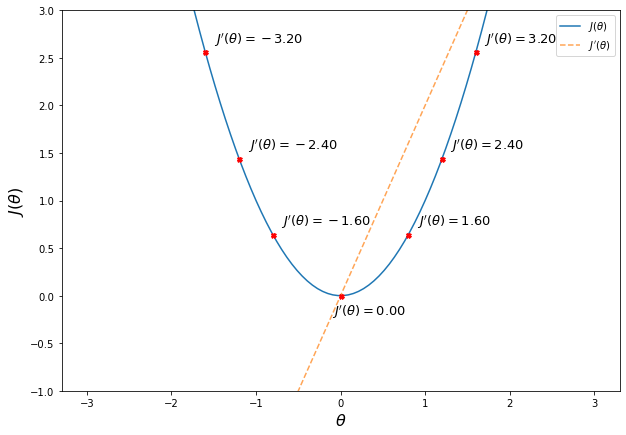

In [10]:
w = np.linspace(-3,3,100)

plt.figure(figsize=(10,7))
plt.plot(w, convex_func(w), label='$J(\\theta)$')
plt.plot(w, slope(w), linestyle='--', label="$J'(\\theta)$", alpha=.7)
 
for x in [-1.6, -1.2, -.8, .8, 1.2, 1.6]:
    plt.plot(x, convex_func(x), marker='X', markersize=5, color='red')
    delta_w = slope(x)
    plt.text(x + .1, convex_func(x) + .1, "$J'(\\theta) = %.2f$" % delta_w, fontsize=13)

plt.plot(0, convex_func(0), marker='X', markersize=5, color='red')
plt.text(-.1, convex_func(0) - .2, "$J'(\\theta) = %.2f$" % slope(0), fontsize=13)
    
plt.ylabel('$J(\\theta)$', fontsize=16)
plt.xlabel('$\\theta$', fontsize=16)
plt.ylim(-1, 3)
plt.legend()
plt.show()

#### Atualização dos pesos

Suponha que estejamos na interação $t$ da descida de gradiente, vamos exemplificar com 3 cenários:


Com $\eta = 0.1$ e $ \theta = -1.2$:

$$\Large \theta^{\,t} = \theta^{\,t-1} - \eta \frac{\partial J}{\partial \theta}$$

$$\Large \theta^{\,t} = -1.2 - 0.1 . (-2.4) \rightarrow -1.2 + 0.24$$

$$\Large \theta^{\,t} = -0.96$$

In [11]:
def gradient_descent(w_init, l_rate, epochs, plot=True):
    w = w_init

    for t in range(epochs):

        cost = convex_func(w)
        delta_w = slope(w)
        
        if plot:
            plt.plot(w, cost, marker='X', markersize=5, color='red')
            plt.text(w + .1, cost, "$w^{%d} = %.2f$" % (t+1, w), fontsize=11)

        w -= l_rate * delta_w

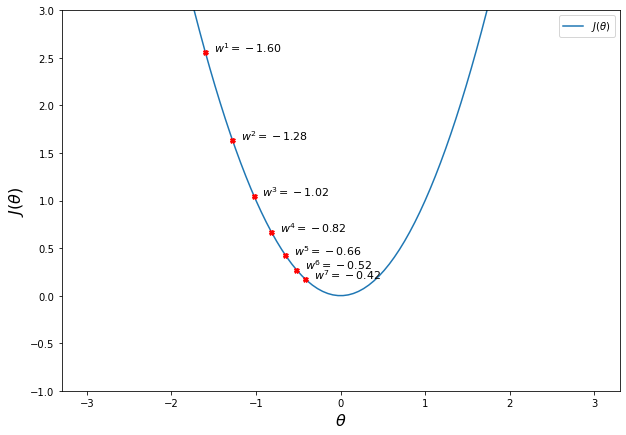

In [12]:
w_space = np.linspace(-3,3,100)

plt.figure(figsize=(10,7))
plt.plot(w_space, convex_func(w_space), label='$J(\\theta)$')

gradient_descent(-1.6, 0.1, 7)

plt.ylabel('$J(\\theta)$', fontsize=16)
plt.xlabel('$\\theta$', fontsize=16)
plt.ylim(-1, 3)
plt.legend()
plt.show()

$$\Large J(w) = w^2_1 + w^2_2$$

Dot product do vetor de pesos

In [13]:
convex_func = lambda x: x.dot(x)

$$\Large \nabla_w J = \begin{bmatrix} \frac{\partial J}{\partial w_1}&\frac{\partial J}{\partial w_2}\end{bmatrix}$$

$$\Large \frac{ \partial J}{\partial w_1} = \frac{\partial}{\partial w_1}w^{2}_{1} + \frac{\partial}{\partial w_1}w^{2}_{2}$$

$$\Large \frac{ \partial J}{\partial w_1} = 2w^{(2-1)}_{1} + 0 = 2w_1$$

$$\Large \frac{ \partial J}{\partial w_2} = 0 + 2w^{(2-1)}_{2} = 2w_2$$

$$\Large \nabla_w J = \begin{bmatrix} 2w_1&2w_2\end{bmatrix}$$

In [14]:
w_1 = np.linspace(-2,2, 10)
w_2 = np.linspace(-2,2, 10)
w_space = np.c_[w_1, w_2]

In [15]:
grid_w1, grid_w2 = vs.get_meshgrid(w_space)

In [16]:
grid_w_space = np.c_[grid_w1.ravel(), grid_w2.ravel()]
vs.display_matrix(grid_w_space, n_rows=5, label='\\theta')

<br>$\theta = \begin{bmatrix}-3&-3\\-2.98&-3\\-2.96&-3\\-2.94&-3\\-2.92&-3\end{bmatrix}$<br><br>

Dimensões da matriz: (90000 x 2)



In [17]:
loss = np.array([convex_func(w) for w in grid_w_space]).reshape(grid_w1.shape)
vs.display_matrix(loss, n_rows=5, n_cols=1, label='J(\\theta)')

<br>$J(\theta) = \begin{bmatrix}18\\17.88\\17.76\\17.64\\17.53\end{bmatrix}$<br><br>

Dimensões da matriz: (300 x 300)



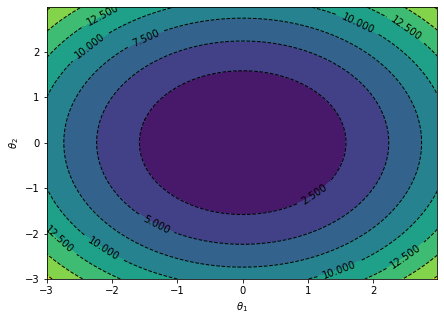

In [18]:
vs.plot_topographic(grid_w1, grid_w2, loss)

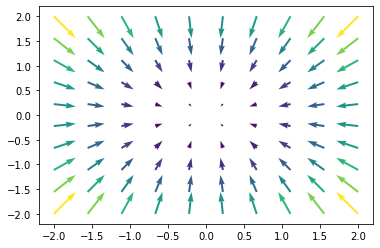

In [19]:
vs.plot_directions(w_1, w_2, convex_func, slope)

In [20]:
def gradient_descent(w_init, l_rate, epochs, loss_func, slope_func, return_data=False):
    w = w_init
    coefs = []
    costs = []
    
    for t in range(epochs):
        cost = loss_func(w)
        delta_w = slope_func(w)
        
        coefs.append(w)
        costs.append(cost)
        
        new_w = w - (l_rate * delta_w)
        w = new_w
    
    if return_data:
        return np.array(coefs), costs

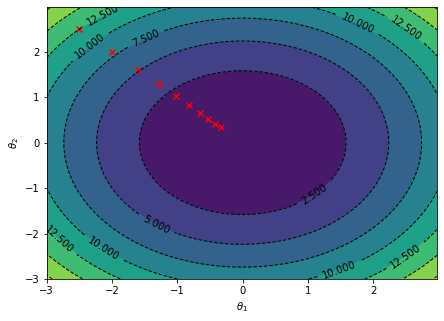

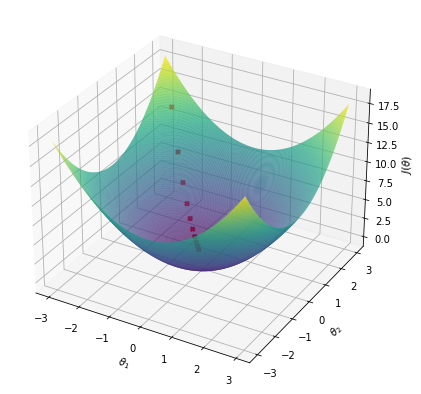

In [21]:
vs.plot_topographic(grid_w1, grid_w2, loss, show=False)

coefs, costs = gradient_descent(
    w_init=np.array([-2.5, 2.5]), 
    l_rate=.1, 
    epochs=10, 
    loss_func=convex_func,
    slope_func=slope,
    return_data=True)

plt.scatter(coefs[:,0], coefs[:,1], marker='x', color='red')

vs.plot_3d_gradient(grid_w1, grid_w2, loss, coefs=coefs, costs=costs)

## 3. Melhorias no algoritmo



$$\Large J(w_1, w_2) = w_1 \sin (w_2) - \cos (w_1)$$

In [22]:
non_convex_func = lambda w: (w[0] * np.sin(w[1])) - np.cos(w[0])

$$\Large \frac{ \partial J}{\partial w_1} = \sin(w_2) + \sin(w_1)$$

$$\Large \frac{ \partial J}{\partial w_2} = w_1 \cos(w_2)$$

$$\Large \nabla_w J = \begin{bmatrix} \sin(w_2) + \sin(w_1)&w_1 \cos(w_2)\end{bmatrix}$$

In [23]:
slope_non_convex = lambda w: np.array([(3*w[0])**2 * w[1], w[0]**3])

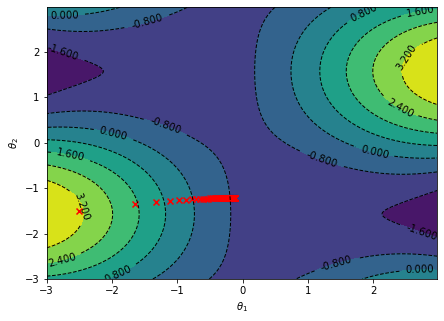

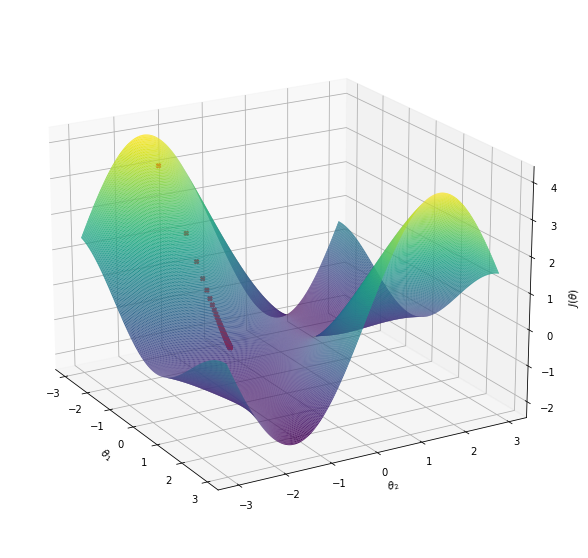

In [24]:
loss = np.array([non_convex_func(w) for w in grid_w_space]).reshape(grid_w1.shape)

vs.plot_topographic(grid_w1, grid_w2, loss, show=False)

coefs, costs = gradient_descent(
    w_init=np.array([-2.5,-1.5]), 
    l_rate=.01, 
    epochs=70, 
    loss_func=non_convex_func,
    slope_func=slope_non_convex,
    return_data=True)

plt.scatter(coefs[:,0], coefs[:,1], marker='x', color='red')

vs.plot_3d_gradient(grid_w1, grid_w2, loss, angles=(20,-30), size=(12,10), coefs=coefs, costs=costs)

In [25]:
slope_non_convex_array = lambda W: np.array([[(3*w[0])**2 * w[1], w[0]**3] for w in W])

In [26]:


max_iters = 3
error = np.zeros(max_iters + 1)

for t in range(1, max_iters + 1):
    error[t] += 1

np.allclose

<function numpy.allclose(a, b, rtol=1e-05, atol=1e-08, equal_nan=False)>

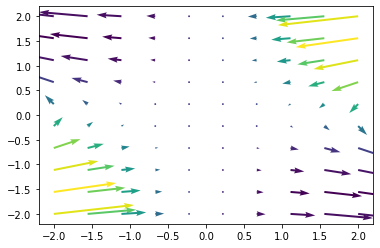

In [27]:
vs.plot_directions(w_1, w_2, non_convex_func, slope_non_convex_array)


## 3. Melhorias no algoritmo

### 3.1 Atualização de learning rate

<img src='https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png'>

#### 3.1.1 Time-based decay

$$\Large \eta^{(t)} = \frac{\eta^{(0)}} {1 + \alpha t}$$

Onde $\eta_0$ representa a taxa de aprendizagem inicial. (No pacote sklearn por exemplo, esse parâmetro costuma ser chamado de `learning_rate_innit`. Já $\alpha$ é a taxa de decaimento, `decay`em inglês

In [28]:
def time_based_lr_decay(lr_init, decay, t):
    return lr_init / (1 + decay*t)    

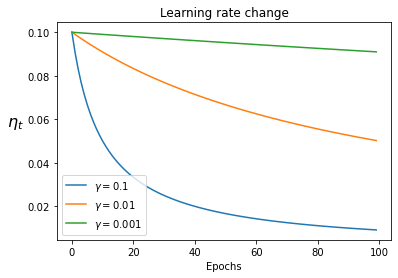

In [29]:
epochs = 100

plt.plot([time_based_lr_decay(.1, .1, t) for t in range(epochs)], label='$\gamma = 0.1$')
plt.plot([time_based_lr_decay(.1, .01, t) for t in range(epochs)], label='$\gamma = 0.01$')
plt.plot([time_based_lr_decay(.1, .001, t) for t in range(epochs)], label='$\gamma = 0.001$')
plt.legend()
plt.title('Learning rate change')
plt.ylabel('$\eta_t$    ', fontsize=16, rotation=0)
plt.xlabel('Epochs')
plt.show()

#### 3.1.2 Step decay

$$\Large \eta^{(t)} = \eta^{(0)}. \gamma^{\left \lfloor \frac{t}{s} \right \rfloor}$$

Onde $\gamma$ novamente representa a taxa de decaimento, e $s$ representa a quantidade de épocas necessárias para haver uma nova atualização na taxa de aprendizado. Por exemplo, supondo que $s = 10$, isso significa que a taxa vai decair a cada 10 interações. Um outro ponto de atenção, é a função que está sendo aplicada ao expoente! A função __floor__, representada pela notação $\left \lfloor \,\, \right \rfloor$ é o arredondamento de um valor decimal para o primeiro inteiro menor que o valor:

$$\Large \left \lfloor 2.8 \right \rfloor = 2$$

Analogamente, a função __ceil__ faz o contrário, e arredonda sempre pra cima. Ambas as funções existem dentro da biblioteca built in `math`:

In [30]:
def step_decay_lr(lr_init, decay, s, t):
    schedule = math.floor((t+1)/s)
    return lr_init * decay**schedule        

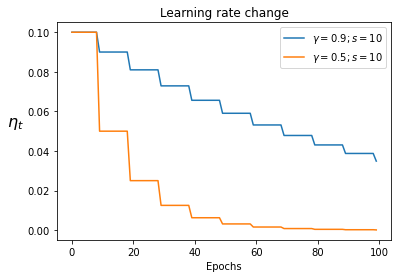

In [31]:
epochs = 100

plt.plot([step_decay_lr(.1, .9, 10, t) for t in range(epochs)], label='$\gamma = 0.9 ; s = 10$')
plt.plot([step_decay_lr(.1, .5, 10, t) for t in range(epochs)], label='$\gamma = 0.5 ; s = 10$')
plt.legend()
plt.title('Learning rate change')
plt.ylabel('$\eta_t$    ', fontsize=16, rotation=0)
plt.xlabel('Epochs')
plt.show()

In [32]:
def set_lr_schedule(lr_init, decay, s):
    """
    Recebe os parâmetros relacionados a learning rate e retorna a função adequada
    Argumentos:
    lr_init = taxa de aprendizado inicial (eta0)
    decay = taxa de decaimento da taxa de aprendizagem
    s = de "schedule", se passado, determina de quantas em quantas épocas a taxa de aprendizado vai decair
    Retorna: um callable que recebe como único argumento "t" que representa a t-ésima época
    """
    # Se decay e s forem do tipo None
    if all(x is None for x in [decay, s]):
        # Usa learning rate constante igual ao valor inicial passado
        return lambda t: lr_init
    else:        
        if s is None:
            # se apenas o decay for passado, usa o time-based decay
            return lambda t: lr_init / (1 + decay*t)
        else:
            # se "s" também for passado junto com o decay, usa o step-decay
            return lambda t: lr_init * decay**math.floor((t+1)/s)

### 3.2 Momentum

$$\Large \nu_t = \beta \nu_{t - 1} + \eta \nabla_{w} J$$

Onde $\beta$ representa o parâmetro do momentum sendo que $\beta \in [0,1]$. Com esse vetor de velocidade atualizamos os pesos em direção ao negativo do gradiente da mesma forma que o algoritmo tradicional:

$$\Large w_{t} = w_{t - 1} - \nu_{t}$$

Dessa forma, as três primeiras atualizações do vetor de velocidade do gradiente serão:

- $\Large \nu_1 = \eta \nabla_{w}J$  

- $\Large \nu_2 = \beta \nu_1 + \eta \nabla_{w} J$

- $\Large \nu_3 = \beta \nu_2 + \eta \nabla_{w} J$


E assim por diante. Repare que na primeira interação ($\nu_1$), o vetor de velocidade é simplesmente é o gradiente normal, uma vez que por ser a primeira interação, ainda não existe um momentum associado. Se formos de novo pra física, é como imaginar que na primeira interação o corpo está saindo de repouso. 

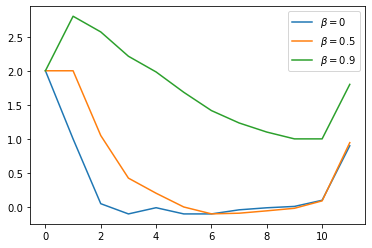

In [33]:
slopes = [0, -2, -1, -.05, 0.1, .009, .1, 0.1, .04, .01, -.01, -.1, -.9] 
epochs = len(slopes) - 1
v1 = np.zeros(epochs + 1)
v2 = np.zeros(epochs + 1)
v3 = np.zeros(epochs + 1)

for t in range(1, epochs + 1):
    v1[t] = 0*v1[t - 1] + slopes[t] * -1
    v2[t] = .5*v2[t - 1] + slopes[t] * -1
    v3[t] = .9*v3[t - 1] + slopes[t] * -1

plt.plot(list(range(epochs)), v1[1:], label='$\\beta = 0$')
plt.plot(list(range(epochs)), v2[1:], label='$\\beta = 0.5$')
plt.plot(list(range(epochs)), v3[1:], label='$\\beta = 0.9$')
plt.legend()

Conciliando essas alterações acima, podemos criar uma nova versão do algoritmo de descida de gradiente estocástico mais robusta, com novos parâmetros para trabalhar. Suponto que usemos o momento e learning rate com decaimento baseado em tempo, teremos a atualização dos pesos da seguinte forma:

$$\Large w_{t} = w_{t - 1} - \beta \nu_{t - 1} + \frac{\eta^{(0)}} {1 + \alpha t} \nabla_{w} J$$

Abaixo é implementado esse novo algoritmo na forma de uma classe:

In [34]:
def SGD_Momentum(w_init, lr_init, epochs, loss_func, slope_func, momentum, decay=None, s=None, return_data=False):
    beta = momentum
    w = w_init
    coefs = []
    costs = []
    V = 0
    
    n = set_lr_schedule(lr_init, decay, s)
    
    for t in range(1, epochs + 1):
        cost = loss_func(w)
        slope = slope_func(w)
        
        V = beta*V + n(t)*slope
        coefs.append(w)
        costs.append(cost)
        
        new_w = w - V
        w = new_w        
    
    if return_data:
        return np.array(coefs), costs    
    

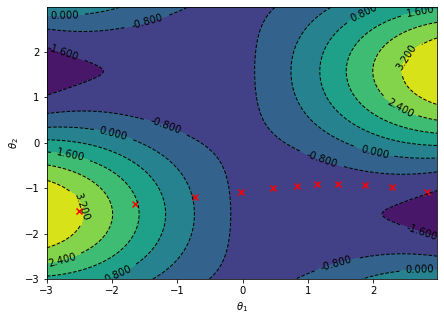

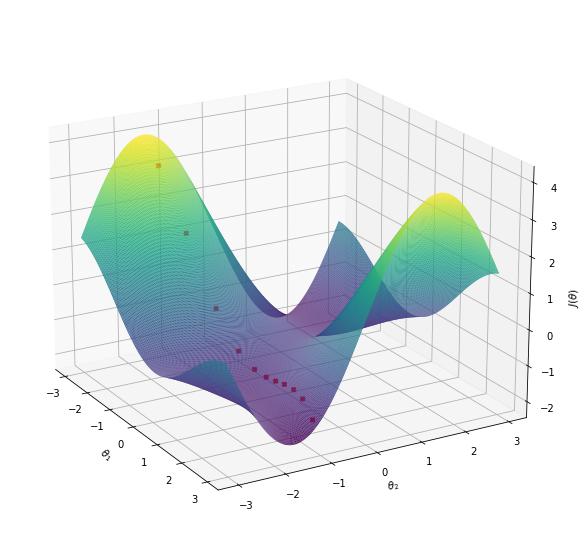

In [35]:
vs.plot_topographic(grid_w1, grid_w2, loss, show=False)

coefs, costs = SGD_Momentum(
    w_init=np.array([-2.5,-1.5]), 
    lr_init=.01, 
    epochs=11, 
    loss_func=non_convex_func,
    slope_func=slope_non_convex,
    momentum=.7,
    decay=.5,
    s=10,
    return_data=True)

plt.scatter(coefs[:,0], coefs[:,1], marker='x', color='red')

vs.plot_3d_gradient(grid_w1, grid_w2, loss, angles=(20,-30), size=(12,10), coefs=coefs, costs=costs)